<a href="https://colab.research.google.com/github/PremNawale3/Student-Performance-Model/blob/main/student_performance_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Student Success — Models Notebook

This notebook implements the models from your research paper:

- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- Artificial Neural Network (ANN)

**Notes**:
- Place your dataset CSV (e.g., `student-mat.csv`) in the same folder as this notebook before running.
- The uploaded research paper is available at the local path below for reference.

**Uploaded paper path:** `/mnt/data/Professional_Research_Paper_TNR.docx`

----
## Objectives
1. Data loading and cleaning
2. Feature encoding and scaling
3. Train/test split (80:20)
4. Train the four models
5. Evaluate and compare (accuracy, precision, recall, F1, ROC AUC)
6. Feature importance analysis (Random Forest)
7. Save best model


In [35]:
# IMPORTS
# -----------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("/content/Students_data[1].csv")
print("Dataset Loaded:", df.shape)

Dataset Loaded: (105, 17)


In [ ]:
print(df.columns)


Index(['ID', 'class', 'gender', 'race', 'GPA', 'Algebra', 'Calculus1',
       'Calculus2', 'Statistics', 'Probability', 'Measure',
       'Functional_analysis', 'from1', 'from2', 'from3', 'from4', 'y'],
      dtype='object')


In [23]:
# List of all subject score columns
subject_cols = [
    'GPA', 'Algebra', 'Calculus1', 'Calculus2',
    'Statistics', 'Probability', 'Measure', 'Functional_analysis'
]

# Compute average score
df['Average_Score'] = df[subject_cols].mean(axis=1)

# Create Pass/Fail label
df['Pass'] = (df['Average_Score'] >= 60).astype(int)

df.head()


,ID,class,gender,race,GPA,Algebra,Calculus1,Calculus2,Statistics,Probability,Measure,Functional_analysis,from1,from2,from3,from4,y,Average_Score,Pass
0,1141,A,male,1,73.47,64,81,87,60,74,71,60,A,A,A,3,0,71.30875,1
1,1142,A,female,1,71.22,57,50,51,51,55,62,61,B,A,A,2,0,57.27750,0
2,1143,A,female,2,74.56,47,48,71,60,61,68,64,C,A,A,0,1,61.69500,1
3,1144,A,female,1,72.89,46,72,38,60,29,54,51,D,A,A,0,0,52.86125,0
4,1145,A,female,1,70.11,49,45,63,60,66,66,61,E,A,A,0,0,60.01375,1


In [24]:
# STEP 3: SEPARATE FEATURES & LABEL
# ------------------------------
X = df.drop(columns=['Pass'])
y = df['Pass']


In [25]:
# STEP 4: ENCODE CATEGORICAL FEATURES
# ------------------------------
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

In [26]:
# STEP 5: TRAIN/TEST SPLIT
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
# STEP 6: SCALING NUMERIC FEATURES
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Split Done — Train:", X_train.shape, "Test:", X_test.shape)

Split Done — Train: (84, 18) Test: (21, 18)


In [29]:
# HELPER: METRICS FUNCTION
# ------------------------------
results = {}

def eval_model(name, y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    }


In [32]:
# Convert results dictionary into DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


Empty DataFrame
Columns: []
Index: []


In [36]:
# MODEL 1: LOGISTIC REGRESSION
# -----------------------------------------
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
eval_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr)


In [37]:
# MODEL 2: RANDOM FOREST
# -----------------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
eval_model("Random Forest", y_test, y_pred_rf, y_prob_rf)

In [38]:
# MODEL 3: SVM
# -----------------------------------------
svm = SVC(probability=True)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]
eval_model("SVM", y_test, y_pred_svm, y_prob_svm)

In [39]:
# MODEL 4: ANN
# -----------------------------------------
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred_ann = (model.predict(X_test_scaled) >= 0.5).astype(int).flatten()
y_prob_ann = model.predict(X_test_scaled).flatten()
eval_model("ANN", y_test, y_pred_ann, y_prob_ann)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0657 - loss: 0.9486 - val_accuracy: 0.0000e+00 - val_loss: 0.8301
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.2533 - loss: 0.7890 - val_accuracy: 0.6667 - val_loss: 0.6974
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.6130 - loss: 0.6872 - val_accuracy: 0.8889 - val_loss: 0.5881
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8329 - loss: 0.5990 - val_accuracy: 1.0000 - val_loss: 0.4999
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9421 - loss: 0.5247 - val_accuracy: 1.0000 - val_loss: 0.4276
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9749 - loss: 0.4607 - val_accuracy: 1.0000 - val_loss: 0.3704
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9632 - loss: 0.4279 - val_accuracy: 1.0000 - val_loss: 0.3249
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9632 - loss: 0.3867 - val_accuracy: 1.0000 - val_loss:

In [40]:
# 7. RESULTS TABLE
# -----------------------------------------
results_df = pd.DataFrame(results).T
print("\n\n===== FINAL MODEL COMPARISON =====")
print(results_df)



===== FINAL MODEL COMPARISON =====
                     accuracy  precision  recall       f1  roc_auc
Logistic Regression  0.952381   0.952381     1.0  0.97561      0.9
Random Forest        0.952381   0.952381     1.0  0.97561      0.9
SVM                  0.952381   0.952381     1.0  0.97561      0.9
ANN                  0.952381   0.952381     1.0  0.97561      0.2


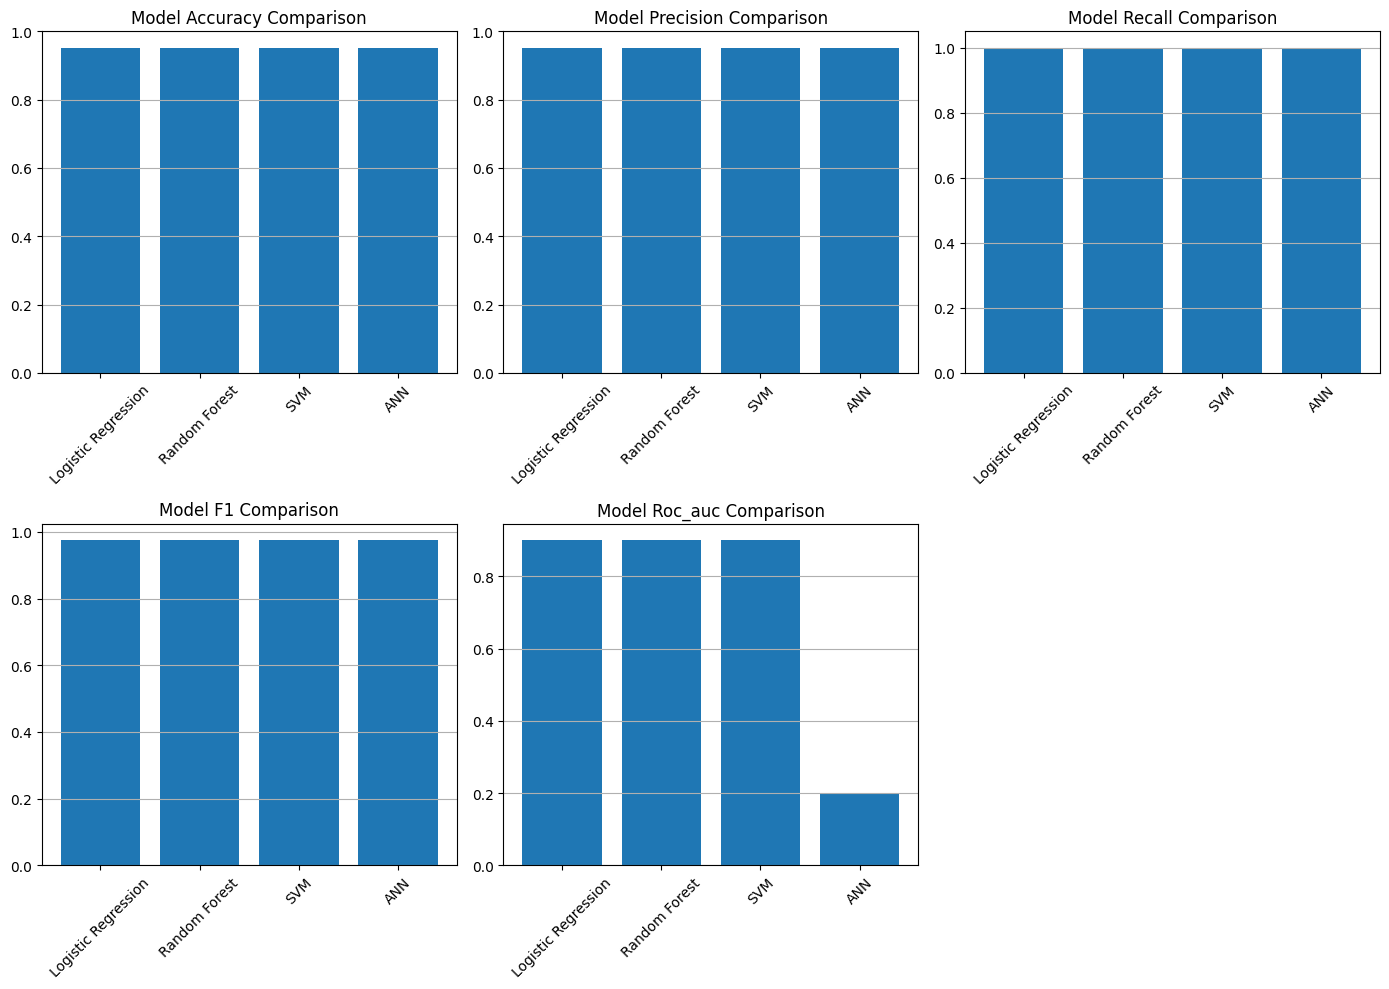

In [45]:
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

plt.figure(figsize=(14,10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(results_df.index, results_df[metric])
    plt.title(f"Model {metric.capitalize()} Comparison")
    plt.xticks(rotation=45)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()


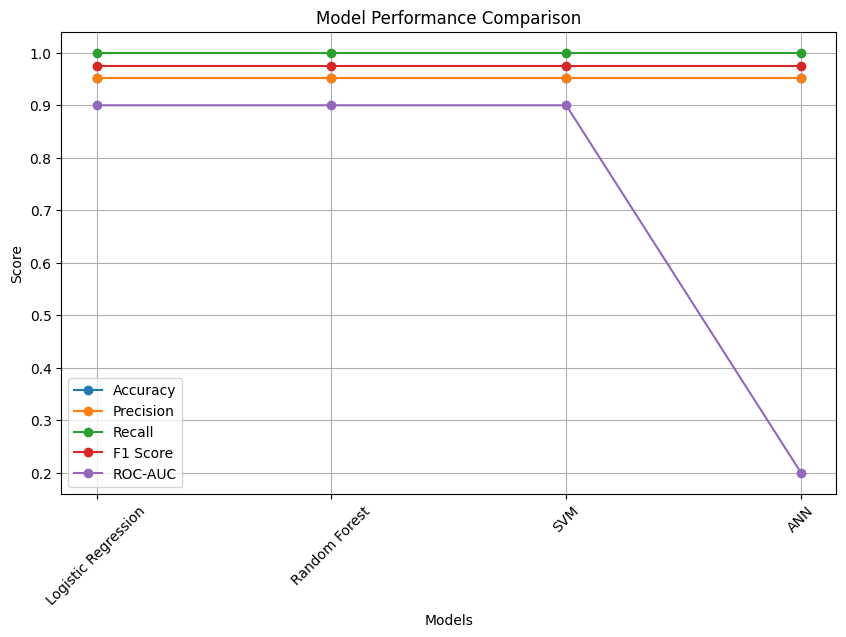

In [46]:
plt.figure(figsize=(10,6))
plt.plot(results_df.index, results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df.index, results_df['precision'], marker='o', label='Precision')
plt.plot(results_df.index, results_df['recall'], marker='o', label='Recall')
plt.plot(results_df.index, results_df['f1'], marker='o', label='F1 Score')
plt.plot(results_df.index, results_df['roc_auc'], marker='o', label='ROC-AUC')

plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()


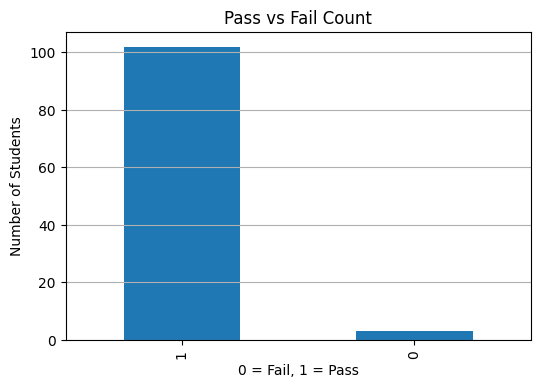

In [47]:
plt.figure(figsize=(6,4))
df['Pass'].value_counts().plot(kind='bar')
plt.title("Pass vs Fail Count")
plt.xlabel("0 = Fail, 1 = Pass")
plt.ylabel("Number of Students")
plt.grid(axis='y')
plt.show()


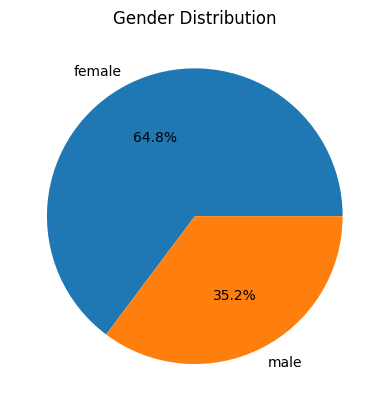

In [50]:
# PIE CHART: Gender Distribution
# ----------------------------
gender_counts = df['gender'].value_counts()

plt.figure()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

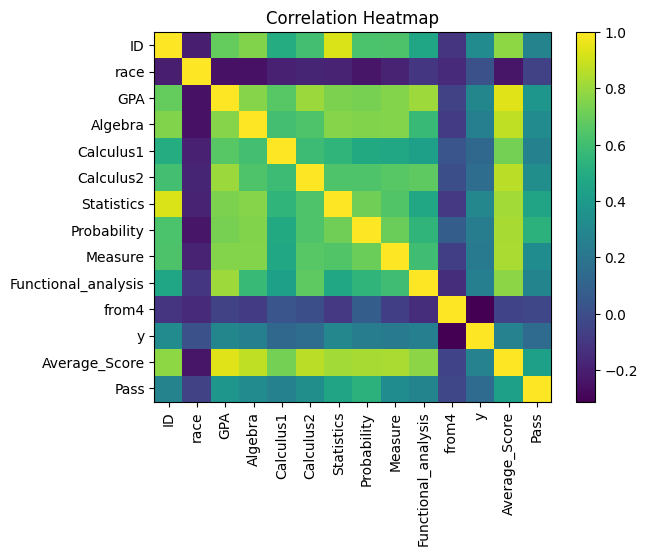

In [51]:
# HEATMAP: Correlation Matrix
# ----------------------------
corr = df.select_dtypes(include='number').corr()

plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.show()

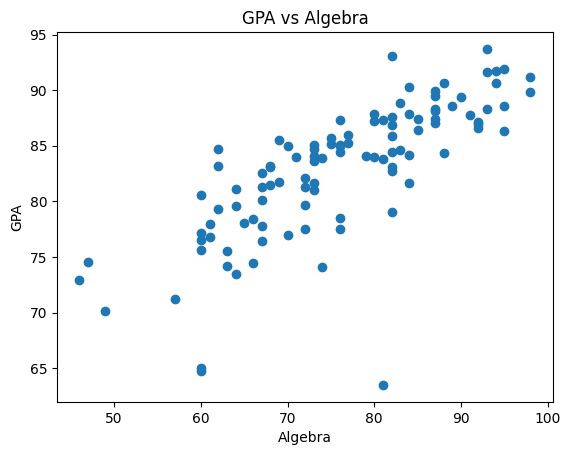

In [52]:
# SCATTER PLOT: GPA vs Algebra
# ----------------------------
plt.figure()
plt.scatter(df['Algebra'], df['GPA'])
plt.xlabel('Algebra')
plt.ylabel('GPA')
plt.title('GPA vs Algebra')
plt.show()